In [1]:
import tables
import pandas as pd
import numpy as np
import cv2
from scipy import stats
import os
import re
from matplotlib import pyplot as plt

In [2]:
def clean_df(df):
    #remove redundant top level
    data = df['DLC_3D']
    #flatten data frame
    data.columns = [' '.join(col).strip() for col in data.columns.values]
    clean = data.copy()
    return data

In [3]:
traj_data = r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\video_data\mitg12\box1_mitg12_09192020104719"
ground_dir = os.path.join(traj_data, 'ground')
print(ground_dir)
df = None
for file in os.listdir(ground_dir):
    if '_3D' in file and 'h5' in file:
        # found the ground 3D file.
        print(file)
        df = pd.read_hdf(os.path.join(traj_data, 'ground', file))
if df is None:
    raise RuntimeError

data = clean_df(df)
data.describe()

F:\MysoreData\nbk\mouseVideoAnalysis\Box1\video_data\mitg12\box1_mitg12_09192020104719\ground
ground_DLC_3D.h5


,bodypart1 x,bodypart1 y,bodypart1 z,bodypart2 x,bodypart2 y,bodypart2 z,bodypart3 x,bodypart3 y,bodypart3 z,bodypart4 x,bodypart4 y,bodypart4 z,bodypart5 x,bodypart5 y,bodypart5 z,bodypart6 x,bodypart6 y,bodypart6 z
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-60.956850,-6.073111,57.569846,-58.526623,-7.208515,57.383397,-56.181546,-5.290331,60.237798,-61.094515,0.342898,63.409413,-58.491463,1.937066,65.502544,-56.530932,1.031741,65.417631
std,0.054036,0.033058,0.088340,0.072925,0.016920,0.088028,0.039318,0.014957,0.058980,0.111374,0.010644,0.225863,0.034640,0.023794,0.058692,0.022987,0.017742,0.051293
min,-61.041615,-6.154665,57.394086,-58.660252,-7.239664,57.215701,-56.237602,-5.315366,60.118850,-61.283606,0.327341,63.145537,-58.539174,1.892376,65.398946,-56.570003,0.997292,65.330097
25%,-60.983825,-6.085517,57.527085,-58.584895,-7.217424,57.321792,-56.216240,-5.302841,60.192588,-61.186506,0.335280,63.208439,-58.512522,1.921726,65.469417,-56.547454,1.019202,65.375675
50%,-60.962055,-6.077659,57.589970,-58.527749,-7.206991,57.391105,-56.181275,-5.290959,60.236625,-61.049435,0.341956,63.342938,-58.497550,1.944881,65.513495,-56.527804,1.034163,65.412778
75%,-60.931170,-6.051810,57.622220,-58.471422,-7.195247,57.443395,-56.152381,-5.278983,60.284924,-61.015178,0.349919,63.617478,-58.475780,1.955759,65.545405,-56.514631,1.045231,65.455709
max,-60.866008,-6.013175,57.715800,-58.411597,-7.181693,57.537375,-56.105492,-5.266681,60.336398,-60.940522,0.361699,63.778445,-58.416112,1.965510,65.609624,-56.493128,1.055431,65.502443


In [4]:
ref_coords = data.iloc[:, list(range(0, 9))]
ref_coords.dropna(inplace=True)
ref_coords.head()
    

f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bodypart1 x,bodypart1 y,bodypart1 z,bodypart2 x,bodypart2 y,bodypart2 z,bodypart3 x,bodypart3 y,bodypart3 z
0,-60.933841,-6.042616,57.556783,-58.660252,-7.233238,57.537375,-56.105492,-5.266681,60.118850
1,-61.041615,-6.090285,57.656673,-58.596547,-7.231679,57.427022,-56.136155,-5.302081,60.200289
2,-61.036393,-6.154665,57.715800,-58.581610,-7.239664,57.497279,-56.215070,-5.268282,60.285540
3,-60.967910,-6.082066,57.620612,-58.450024,-7.202966,57.322545,-56.141766,-5.280613,60.182443
4,-60.866008,-6.013175,57.423426,-58.498887,-7.213063,57.294320,-56.185811,-5.303602,60.236625


g1 is the left of the hole, g2 is the top, g3 if right

In [5]:
g1_coords = data.iloc[:, list(range(0, 3))].to_numpy()
g2_coords = data.iloc[:, list(range(3, 6))].to_numpy()
g3_coords = data.iloc[:, list(range(6, 9))].to_numpy()

g1_vec = np.median(g1_coords, axis=0)
g2_vec = np.median(g2_coords, axis=0)
g3_vec = np.median(g3_coords, axis=0)

print(g1_vec)
print(g2_vec)
print(g3_vec)

[-60.96205515  -6.0776591   57.58996986]
[-58.52774907  -7.2069912   57.39110524]
[-56.18127507  -5.29095914  60.23662537]


i_m is paralel to the ground along the mask

j_m is orthoganal to the ground along the mask

k_m is orthoganal to the mask

In [6]:
i_mr = (g1_vec - g3_vec)
i_m = i_mr / np.linalg.norm(i_mr)

k_mr = np.cross(i_m, (g1_vec - g2_vec))
k_m = k_mr / np.linalg.norm(k_mr)

j_mr = np.cross(i_m, k_m)
j_m = j_mr / np.linalg.norm(j_mr)

#check
print(np.dot(i_m, k_m))
print(np.dot(i_m, j_m))
print(np.dot(k_m, j_m))

0.0
0.0
-5.551115123125783e-17


All bodypart vector must be transformed with T when loaded to move origin to mask coordinate system.

In [7]:
# construct change of basis matrix 
T = np.concatenate([i_m.reshape(-1, 1), j_m.reshape(-1, 1), k_m.reshape(-1, 1)], axis=1).T
print(T)

[[-0.86595347 -0.14249674 -0.47939468]
 [ 0.42552251 -0.7135828  -0.55653408]
 [ 0.26278351  0.68592585 -0.67856507]]


Load all the tracking data and generated transformed csv files

In [29]:
files = os.listdir(traj_data)
sess_name = os.path.basename(os.path.normpath(traj_data))
save_loc = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\transformed", sess_name)
try:
    os.mkdir(save_loc)
except FileExistsError:
    pass

b1_total = []
b2_total = []
b3_total = []

pre_transformed_dfs = []

for f in files:
    if '_3D.h5' in f:
        clip_id = re.split(r'_|-', f)[1]
        trial_df = pd.read_hdf(os.path.join(traj_data, f))
        trial_df = clean_df(trial_df)
        
        #remove empty data on ends
        first = trial_df.first_valid_index()
        last = trial_df.last_valid_index()
        trial_df = trial_df[first:last]

        # interpolate all linearly with limit of 2
        trial_df.interpolate(method='linear', axis=0, limit=2, limit_direction='both', inplace=True, limit_area='inside')
        
        if trial_df.dropna().shape[0] > 30:
            pre_transformed_dfs.append((trial_df.copy(), clip_id))
        
        num_trial = trial_df.dropna().to_numpy()
        
        #transform into mask coordinate system
        num_trial[:, 0:3] = np.matmul(T, num_trial[:, 0:3].T).T
        num_trial[:, 3:6] = np.matmul(T, num_trial[:, 3:6].T).T
        num_trial[:, 6:9] = np.matmul(T, num_trial[:, 6:9].T).T
        
        b1_total.append(num_trial[:, 0:3])
        b2_total.append(num_trial[:, 3:6])
        b3_total.append(num_trial[:, 6:9])


(array([  0.,   0.,   0.,   2.,   0.,  18., 127., 263., 488., 911., 779.,
        500., 268., 159., 103.,  78.,  45.,  45.,  28.,  20.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

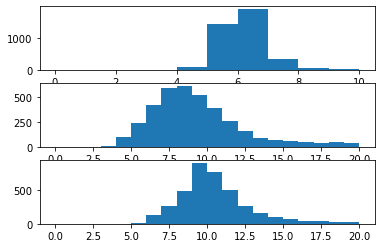

In [30]:
b1 = np.concatenate(b1_total, axis=0)
b2 = np.concatenate(b2_total, axis=0)
b3 = np.concatenate(b3_total, axis=0)

len_ear = np.linalg.norm(b1 - b2, axis=1)
len_left = np.linalg.norm(b3 - b2, axis=1)
len_right = np.linalg.norm(b3 - b1, axis=1)

mean_ear = np.mean(len_ear)
std_ear = np.std(len_ear)
mean_left = np.mean(len_left)
std_left = np.std(len_left)
mean_right = np.mean(len_right)
std_right = np.std(len_right)        

fig, ax = plt.subplots(3)
ax[0].hist(len_ear, bins=10, range=(0, 10), label="ear")
ax[1].hist(len_left, bins=20, range=(0, 20), label="left")
ax[2].hist(len_right, bins=20, range=(0, 20), label="right")

In [31]:
def remove_temporal_outliers(arr: np.ndarray):
    std_arr = .1 * np.std(arr, axis=0)
    for i in range(1, arr.shape[0]):
        mask_pos = arr[i] - arr[i-1] > std_arr
        mask_neg = arr[i] - arr[i-1] < - std_arr
        arr[i][mask_pos] = arr[i-1][mask_pos] + std_arr[mask_pos]
        arr[i][mask_neg] = arr[i-1][mask_neg] - std_arr[mask_neg]
    return arr

In [32]:
sess_name = os.path.basename(os.path.normpath(traj_data))
save_loc = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\transformed", sess_name)
for trial_df, clip_id in pre_transformed_dfs:
    trial_df = trial_df.copy()
    num_trial = trial_df.dropna().to_numpy()
    
    index = np.array(trial_df.dropna().index).astype(np.int)

    #transform into mask coordinate system
    b1 = num_trial[:, 0:3] = np.matmul(T, num_trial[:, 0:3].T).T
    b2 = num_trial[:, 3:6] = np.matmul(T, num_trial[:, 3:6].T).T
    b3 = num_trial[:, 6:9] = np.matmul(T, num_trial[:, 6:9].T).T
    
    trial_df.loc[index, :] = remove_temporal_outliers(num_trial)
    
    len_ear = np.linalg.norm(b1 - b2, axis=1)
    len_left = np.linalg.norm(b3 - b2, axis=1)
    len_right = np.linalg.norm(b3 - b1, axis=1)
    
    out_ear = np.nonzero((mean_ear + .2*mean_ear < len_ear) + (len_ear < mean_ear - .2*mean_ear))
    df_ind_out = index[out_ear]
    trial_df.loc[df_ind_out, trial_df.columns[0:6]] = np.nan
    
    out_left = np.nonzero((mean_left + .2*mean_left < len_left) + (len_left < mean_left - .2*mean_left))
    df_ind_out = index[out_left]
    trial_df.loc[df_ind_out, trial_df.columns[list(range(0,3)) + list(range(6,9))]] = np.nan
    
    out_right = np.nonzero((mean_right + .2*mean_right < len_right) + (len_right < mean_right - .2*mean_right))
    df_ind_out = index[out_right]
    trial_df.loc[df_ind_out, trial_df.columns[3:9]] = np.nan
    
    #another round of very local linear interpolation
    try:
        trial_df.interpolate(method='linear', axis=0, limit=3, limit_direction='both', inplace=True, limit_area='inside')
    except Exception:
        continue
    # do a round of higher order interpolation to try to model bodypart 3 dropped areas
    # trial_df.interpolate(method='quadratic', axis=0, limit=5, limit_direction='both', inplace=True, limit_area='inside')
    
    num_trial = trial_df.dropna().to_numpy()
    index = np.array(trial_df.dropna().index).astype(np.int)
    trial_df.loc[index, :] = remove_temporal_outliers(num_trial)
    
    b1 = num_trial[0:3]
    b2 = num_trial[3:6]
    b3 = num_trial[6:9]
    
    len_ear = np.linalg.norm(b1 - b2, axis=1)
    len_left = np.linalg.norm(b3 - b2, axis=1)
    len_right = np.linalg.norm(b3 - b1, axis=1)
    
    out_ear = np.nonzero((mean_ear + .2*mean_ear < len_ear) + (len_ear < mean_ear - .2*mean_ear))
    df_ind_out = index[out_ear]
    trial_df.loc[df_ind_out, trial_df.columns[0:6]] = np.nan
    
    out_left = np.nonzero((mean_left + .2*mean_left < len_left) + (len_left < mean_left - .2*mean_left))
    df_ind_out = index[out_left]
    trial_df.loc[df_ind_out, trial_df.columns[list(range(0,3)) + list(range(6,9))]] = np.nan
    
    out_right = np.nonzero((mean_right + .2*mean_right < len_right) + (len_right < mean_right - .2*mean_right))
    df_ind_out = index[out_right]
    trial_df.loc[df_ind_out, trial_df.columns[3:9]] = np.nan
    
    #another round of very local linear interpolation
    #trial_df.interpolate(method='linear', axis=0, limit=2, limit_direction='both', inplace=True, limit_area='inside')
    
    # drop any remaining nans
    trial_df.dropna(inplace=True)         
    
    if trial_df.shape[0] > 5:
        print('writing transformed coordinates for clip ', clip_id)
        fname = 'clip_' + str(clip_id) + '_transformed_3D.csv'
        trial_df.to_csv(os.path.join(save_loc, fname))


writing transformed coordinates for clip  0
writing transformed coordinates for clip  10
writing transformed coordinates for clip  12
writing transformed coordinates for clip  13
writing transformed coordinates for clip  14
writing transformed coordinates for clip  15
writing transformed coordinates for clip  16
writing transformed coordinates for clip  18
writing transformed coordinates for clip  19
writing transformed coordinates for clip  20
writing transformed coordinates for clip  21
writing transformed coordinates for clip  22
writing transformed coordinates for clip  24
writing transformed coordinates for clip  25
writing transformed coordinates for clip  26
writing transformed coordinates for clip  27
writing transformed coordinates for clip  28
writing transformed coordinates for clip  31
writing transformed coordinates for clip  33
writing transformed coordinates for clip  35
writing transformed coordinates for clip  36
writing transformed coordinates for clip  38
writing tra

Now we will get angles from transformed coordinates

In [33]:
# # get vector lengths 
# sess_name = os.path.basename(os.path.normpath(traj_data))
# transformed_files = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\transformed", sess_name)
# b1_total = []
# b2_total = []
# b3_total = []
# for f in os.listdir(transformed_files):
#     if '_3D.csv' in f:
#         clip_id = re.split(r'_|-', f)[1]
#         trial_df = pd.read_csv(os.path.join(transformed_files, f))
#         num_trial = trial_df.to_numpy()
        
#         index = num_trial[:, 0].astype(np.int)
        
#         b1_total.append(num_trial[:, 1:4])
#         b2_total.append(num_trial[:, 4:7])
#         b3_total.append(num_trial[:, 7:10])

# b1 = np.concatenate(b1_total, axis=0)
# b2 = np.concatenate(b2_total, axis=0)
# b3 = np.concatenate(b3_total, axis=0)

# len_ear = np.linalg.norm(b1 - b2, axis=1)
# len_left = np.linalg.norm(b3 - b2, axis=1)
# len_right = np.linalg.norm(b3 - b1, axis=1)

# fig, ax = plt.subplots(3)
# ax[0].hist(len_ear, bins=10, range=(0, 10), label="ear")
# ax[1].hist(len_left, bins=20, range=(0, 20), label="left")
# ax[2].hist(len_right, bins=20, range=(0, 20), label="right")



In [34]:
# return the normal vector (orthogonal to the head) and the ear vector (between the two ears)
def get_normals(b1_coords:np.ndarray, b2_coords:np.ndarray, b3_coords:np.ndarray):
    """
    b1_coord: 3D coordinates for left ear base
    b2_coord: 3D coordinates for right ear base 
    b3_coords: 3D coordinates for nose
    """
    ear_vec = b1 - b2
    nose_vec = np.mean(np.stack([(b3 - b1), (b3 - b2)], axis=2), axis=2)
    normal_vec = np.cross(ear_vec, nose_vec)
    normal_vec = normal_vec / np.linalg.norm(normal_vec, axis=1).reshape(-1, 1)
    ear_vec = ear_vec / np.linalg.norm(ear_vec, axis=1).reshape(-1, 1)
    nose_vec = nose_vec / np.linalg.norm(nose_vec, axis=1).reshape(-1, 1) * -1
    return normal_vec, ear_vec, nose_vec

In [35]:
def compute_roll(vec):
    proj = vec[:, (0, 1)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([1, 0])))
    return angle

def compute_pitch(vec):
    proj = vec[:, (1, 2)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([1, 0])))
    return angle

def compute_yaw(vec):
    proj = vec[:, (0, 2)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([0, 1])))
    return angle

f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
f:\mysoredata\nbk\mousevideoanalysis\dlc_env_conda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

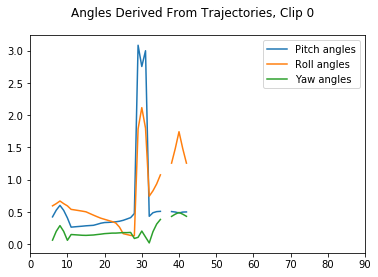

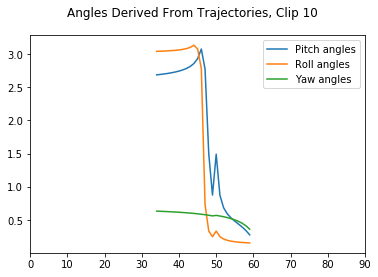

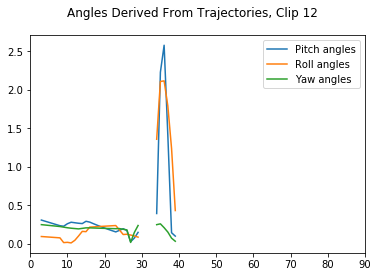

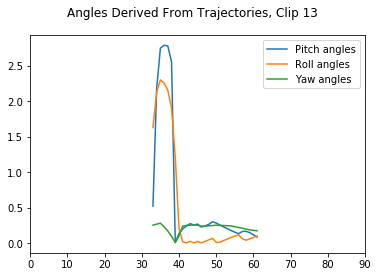

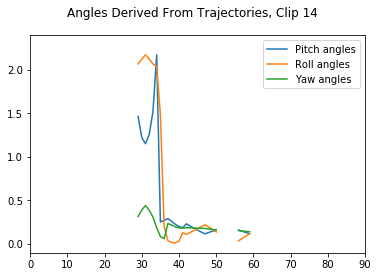

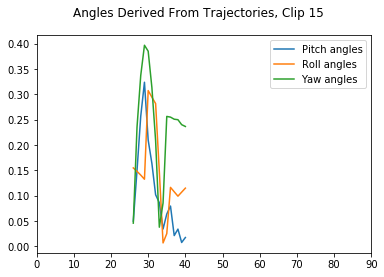

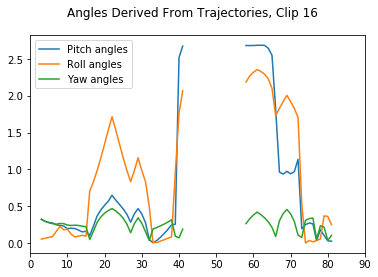

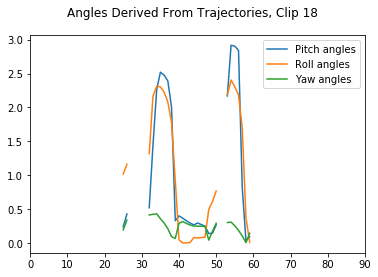

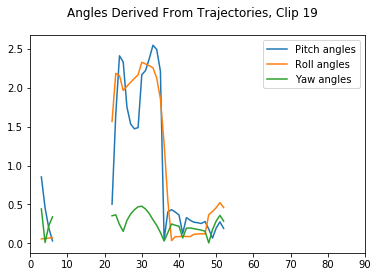

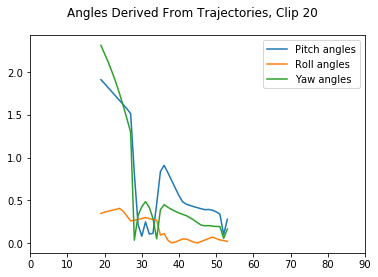

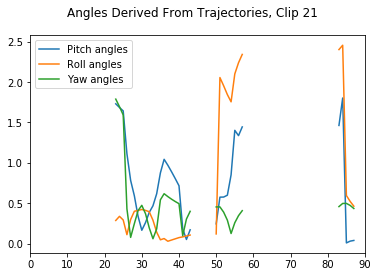

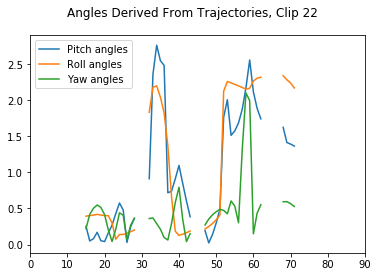

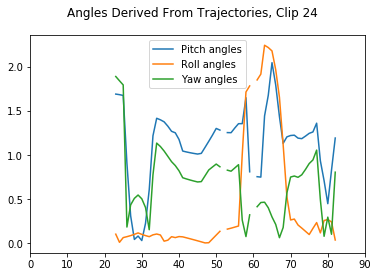

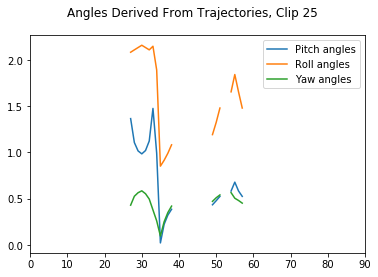

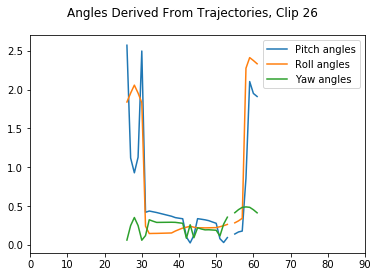

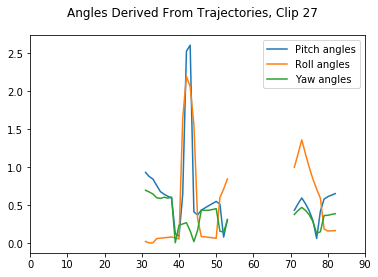

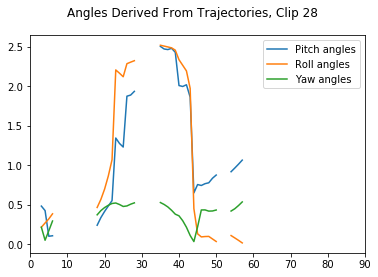

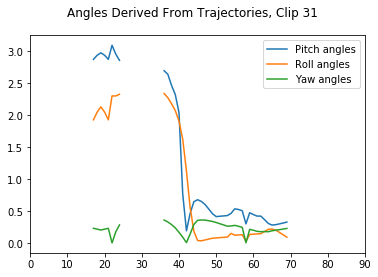

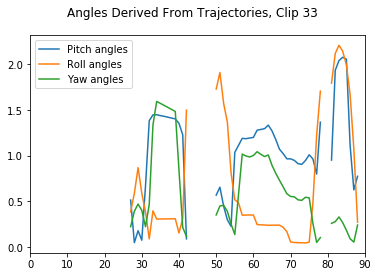

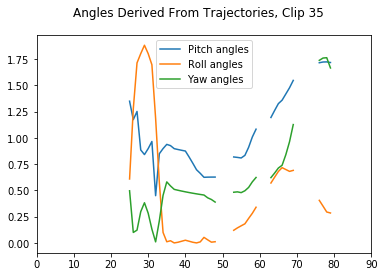

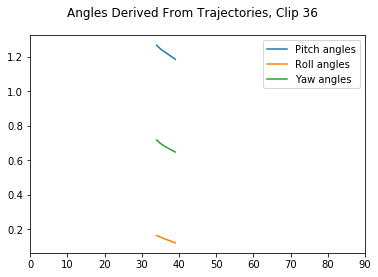

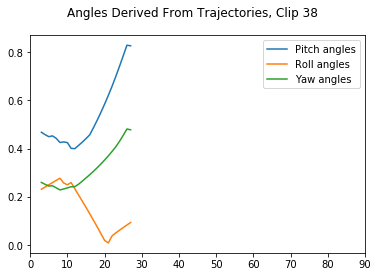

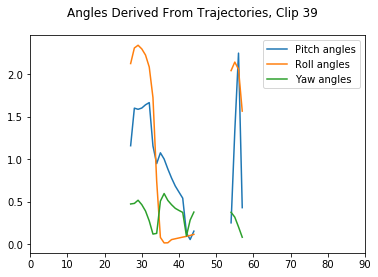

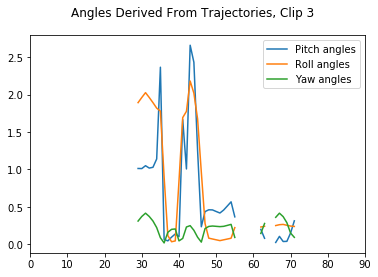

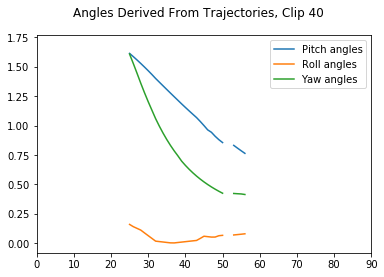

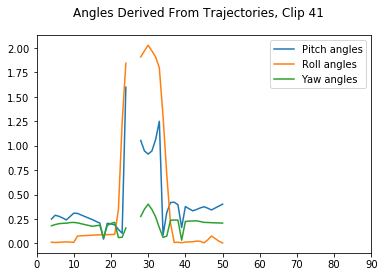

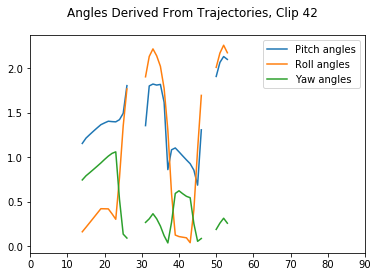

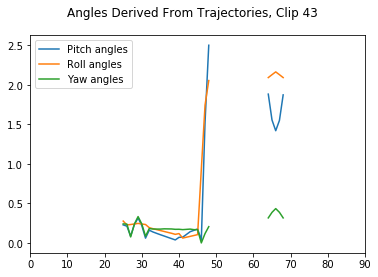

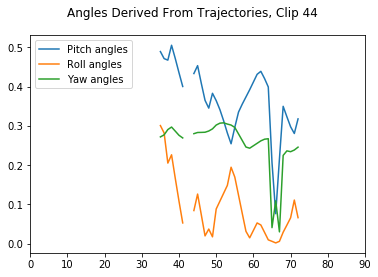

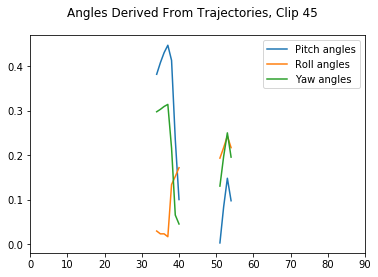

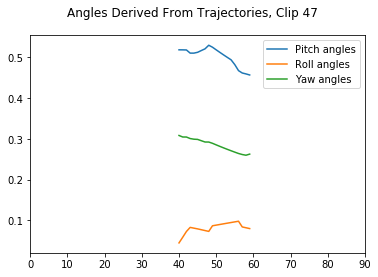

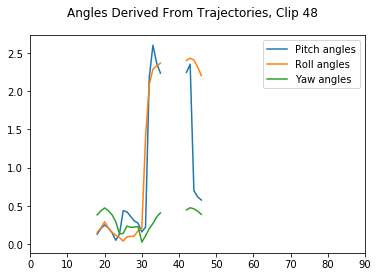

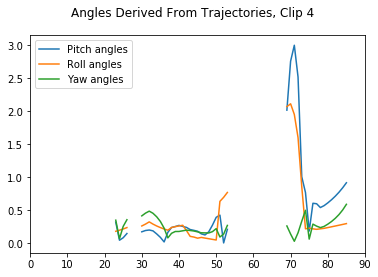

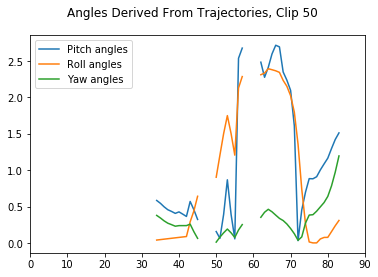

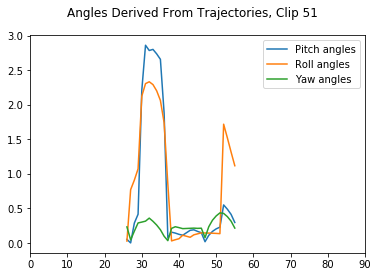

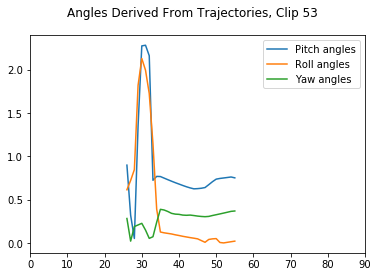

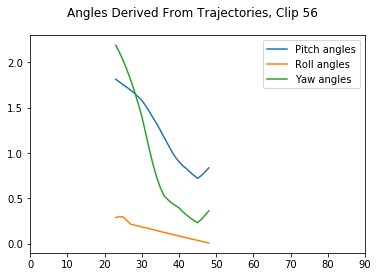

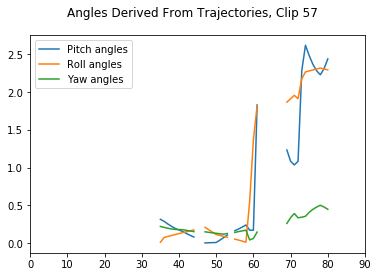

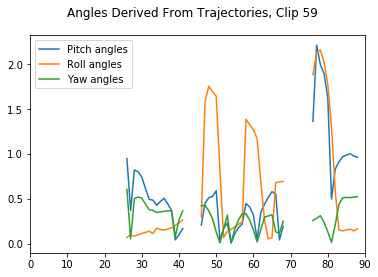

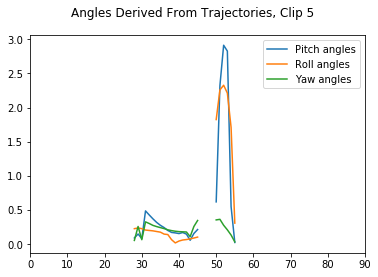

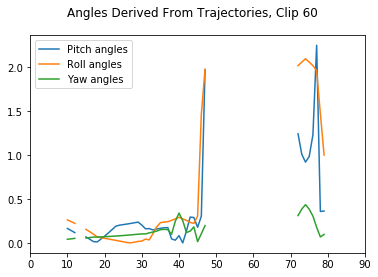

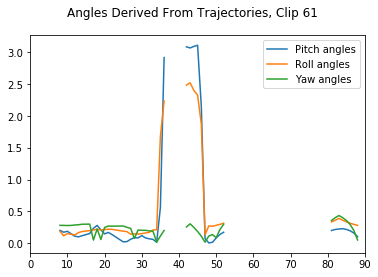

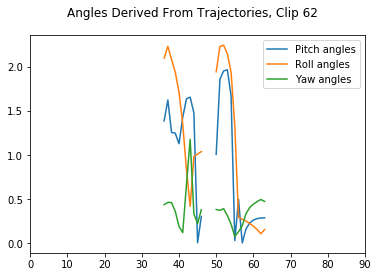

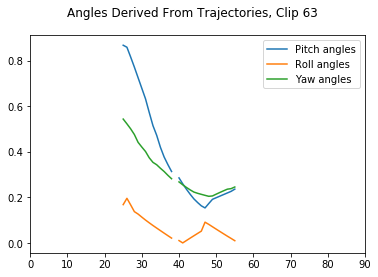

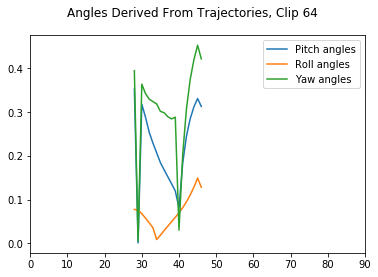

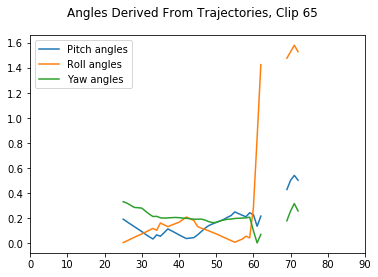

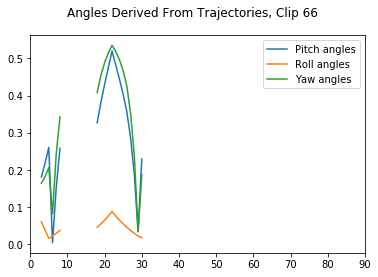

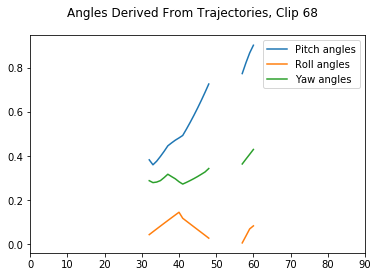

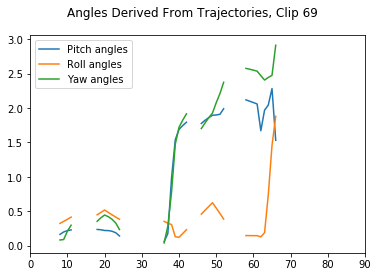

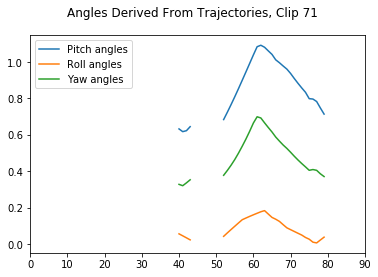

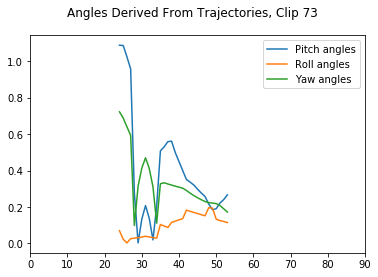

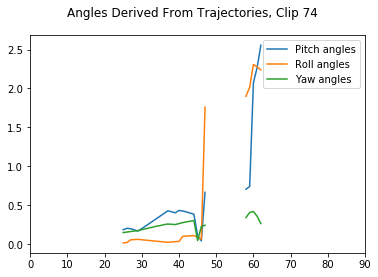

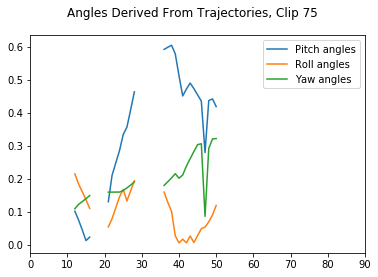

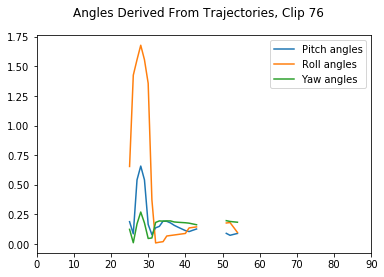

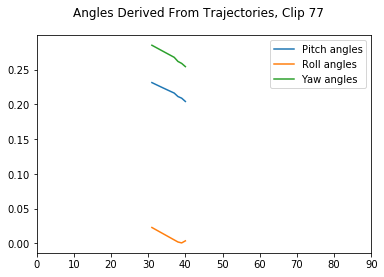

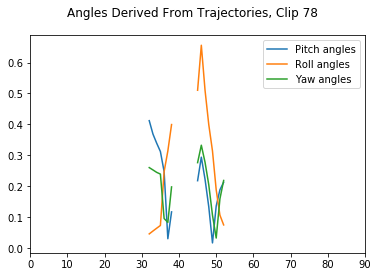

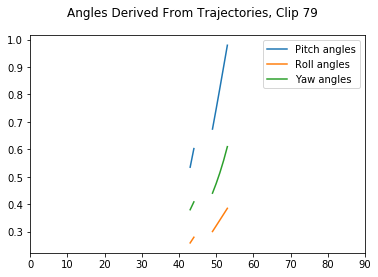

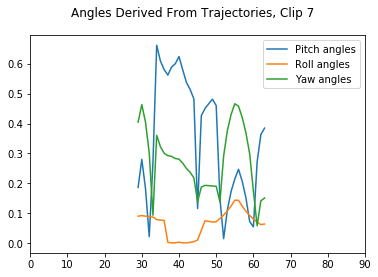

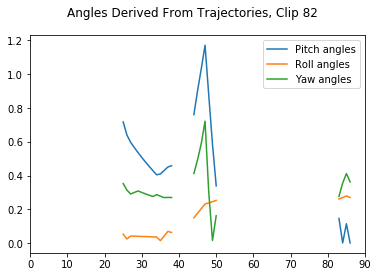

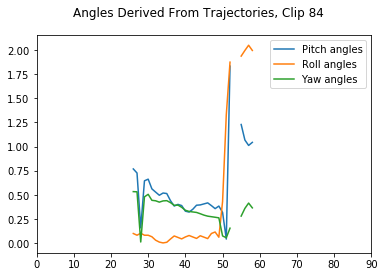

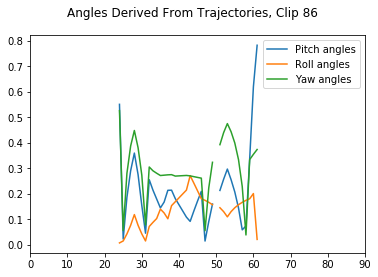

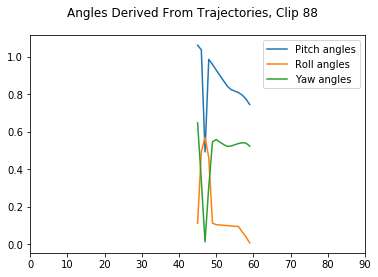

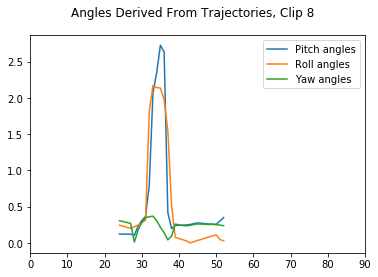

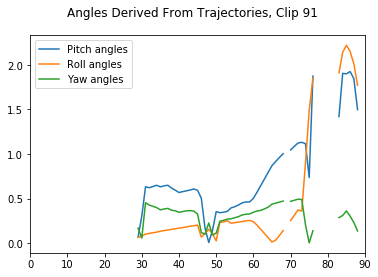

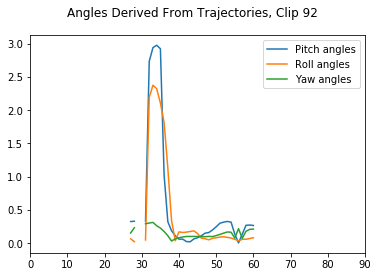

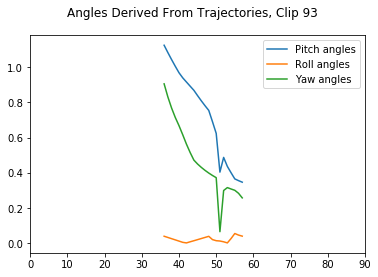

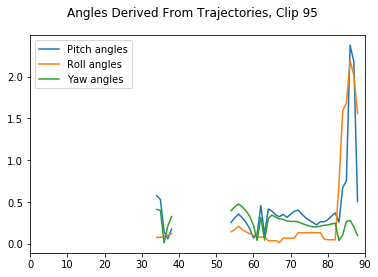

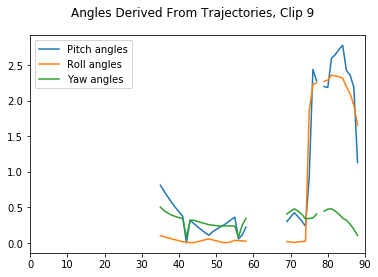

In [36]:
sess_name = os.path.basename(os.path.normpath(traj_data))
transformed_files = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\transformed", sess_name)
save_loc = os.path.join(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\angles", sess_name)
try:
    os.mkdir(r"F:\MysoreData\nbk\mouseVideoAnalysis\Box1\analysis\angles")
except FileExistsError:
    pass
try:
    os.mkdir(save_loc)
except FileExistsError:
    pass
try:
    os.mkdir(os.path.join(save_loc, 'plots'))
except FileExistsError:
    pass
for f in os.listdir(transformed_files):
    if '_3D.csv' in f:
        clip_id = re.split(r'_|-', f)[1]
        trial_df = pd.read_csv(os.path.join(transformed_files, f))
        num_trial = trial_df.to_numpy()
        
        index = num_trial[:, 0].astype(np.int)
        
        b1 = num_trial[:, 1:4]
        b2 = num_trial[:, 4:7]
        b3 = num_trial[:, 7:10]
        
        norm, ear, nose = get_normals(b1, b2, b3)
        roll_angles = compute_roll(ear)
        pitch_angles = compute_pitch(norm)
        yaw_angles = compute_yaw(nose)
        
        roll_map = np.empty([90]) * np.nan
        pitch_map = np.empty([90]) * np.nan
        yaw_map = np.empty([90]) * np.nan
        
        roll_map[index] = roll_angles
        pitch_map[index] = pitch_angles
        yaw_map[index] = yaw_angles
        
        df = pd.DataFrame(np.stack([pitch_angles, yaw_angles, roll_angles], axis=1), columns=["Pitch", "Yaw", "Roll"])
        df.to_csv(os.path.join(save_loc, "unfiltered_angles_clip_" + str(clip_id) + ".csv"))
        
        fig, ax = plt.subplots()
        ax.plot(np.arange(90), pitch_map, label="Pitch angles")
        ax.plot(np.arange(90), roll_map, label="Roll angles")
        ax.plot(np.arange(90), yaw_map, label="Yaw angles")
        ax.set_xlim(0, 90)
        fig.suptitle("Angles Derived From Trajectories, Clip " + str(clip_id))
        ax.legend()
        fig.savefig(os.path.join(save_loc, "plots", "unfiltered_plot_clip_" + str(clip_id) + ".png"), format='png')

- after training network again (double the amount of data )
- discard points outside 10% range on vector length 
- angle plot without interpolation, and with 